# False clouds in ABI static features

Clouds that do not move or evolve are more likely to be false clouds. This program overlays ABI imagery in order to see which features do not evolve with time. 

ABI data is from /mnt/grb/goes16/ on smiller2

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from sklearn.preprocessing import normalize
import fnmatch
import pickle

In [2]:
date = "20220914"

root = "/home/jturner/false_low_clouds_2023/Static_Features/"+date

path = "/home/jturner/false_low_clouds_2023/Static_Features/estimation_data"

Filter to the region

In [3]:
#---CONUS
min_lon = -126
min_lat = 24.5
max_lon = -64
max_lat = 49.5

In [4]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    # Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [5]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

Building a sample BTD to initialize the run over the range of times

In [6]:
data_07 = xr.open_dataset(root+'/OR_ABI-L1b-RadF-M6C07_G16_s20222570500207_e20222570509526_c20222570509568.nc')
data_14 = xr.open_dataset(root+'/OR_ABI-L1b-RadF-M6C14_G16_s20222570500207_e20222570509515_c20222570509597.nc')

ds_07 = calc_latlon(data_07)
ds_14 = calc_latlon(data_14)

lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))
subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))

T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

BTD = T_14 - T_07

## Creating the Static Elements for the date

In [ ]:
#--- Initialize the 2D summed array with zeroes

BTD_prod = [ [1]*len(BTD[0]) for i in range(len(BTD))]

#--- For each of the files in dir, crop and calculate BTD

for filename in os.listdir(root):
    
    #--- To avoid duplicates, loop through only Band 07 data
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C07':
        
        print(filename)
            
        data_07 = xr.open_dataset(root+'/'+filename)
        
        print('Processing 07 band for '+filename[27:31]+'-'+filename[31:34]+' '+filename[34:36]+':'+filename[36:38])

        ds_07 = calc_latlon(data_07)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

        subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))
        
        #--- Search for corresponding Band 14 file:
        files = os.listdir(root) 
        pattern = 'OR_ABI-L1b-RadF-M6C14*'+filename[27:38]+'*.nc'
        filename_14 = str(fnmatch.filter(files, pattern)[0])
        
        print(filename_14)
    
        data_14 = xr.open_dataset(root+'/'+filename_14)
        
        print('Processing 14 band for '+filename_14[27:31]+'-'+filename_14[31:34]+' '+filename_14[34:36]+':'+filename_14[36:38])

        ds_14 = calc_latlon(data_14)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_14, lats, lons)

        subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))
        
        #--- Calculate BTD and take product of the data over time
        T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
        T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

        BTD = T_14 - T_07
        
        
        #--- set negative values to zero
        BTD_lim = np.where(BTD < 0, 0, BTD)
        
        #--- take product of new time step against previous
        BTD_prod = BTD_prod*BTD_lim
        
        #--- limit to between zero and 3
        #--- this slightly dulls the sharp edges of the FLC signal
        BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)
levels = np.linspace(0, 3, 31)

c=ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD_prod, cmap=cmap, levels=levels, extend='max')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

In [ ]:
file = open(path+"/"+date+"_static_elements", 'wb')
BTD_file = pickle.dump(BTD_prod, file)
file.close()

## Loading the Static Elements for the date

In [7]:
file = open(path+"/"+date, 'rb')
BTD = pickle.load(file)
file.close()

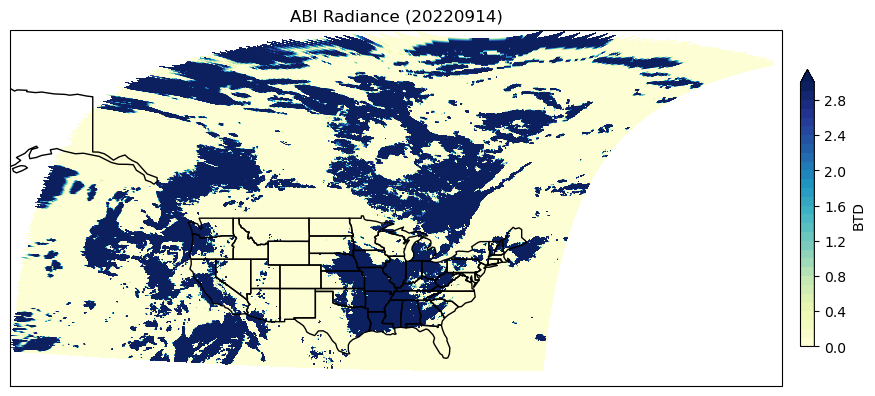

In [8]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)
levels = np.linspace(0, 3, 31)

c=ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD, cmap=cmap, levels=levels, extend='max')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

## Processing the FLC index

In [9]:
time = "00z"

index_root = "/home/jturner/false_low_clouds_2023/Model/Time_Lapse/time_"+time+"/"

In [10]:
sst_file = index_root+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

Adjustment for 360 degree longitudes

In [11]:
max_lon_360 = max_lon + 360
min_lon_360 = min_lon + 360

In [12]:
t = xr.open_dataset(index_root+date+'/t_'+date+'.nc')
q = xr.open_dataset(index_root+date+'/q_'+date+'.nc')

In [13]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon_360,max_lon_360))
t = t.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon_360,max_lon_360))
q = q.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon_360,max_lon_360))

In [14]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = t.t[0:begin,0:end]

diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

In [15]:
bottom_lim = -4

diff_np = np.asarray(diff).copy()
under_zero = diff_np < bottom_lim
diff_np[under_zero] = bottom_lim

In [16]:
top_T = 4

diff_norm = diff_np/(top_T - bottom_lim)

In [17]:
top_q = 0.016
bottom_q = 0.000
q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

In [18]:
flc_index = diff_norm*q_norm

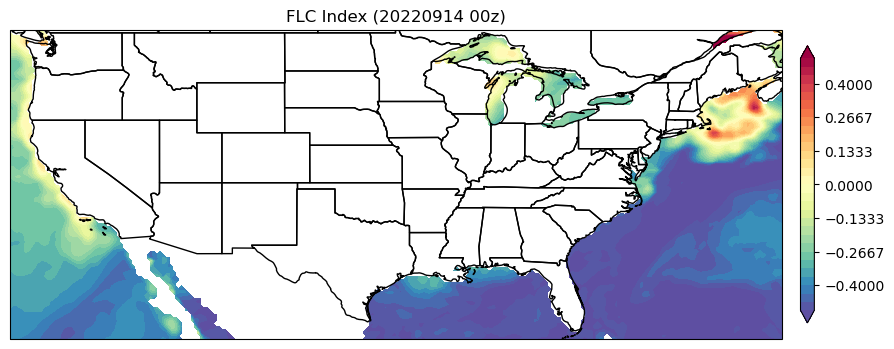

In [19]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.5, 0.5, 31)

c=ax.contourf(dims.longitude, dims.latitude, flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index ('+date+' '+ time+')')
clb.set_label('')

ax.add_feature(cfeature.STATES)

## Estimating SST impact only using FLC index

In [20]:
row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

flc_xr = xr.Dataset(
    data_vars=dict(
        flc_index=(["x","y"], flc_index)
    ),
    coords=dict(
        latitude=(["x","y"], row_meshgrid),
        longitude=(["x","y"], col_meshgrid),
    ),
    attrs=dict(description="FLC index in the designated region"),
)

In [21]:
flc_above = flc_xr.where(flc_xr.flc_index > 0.15)

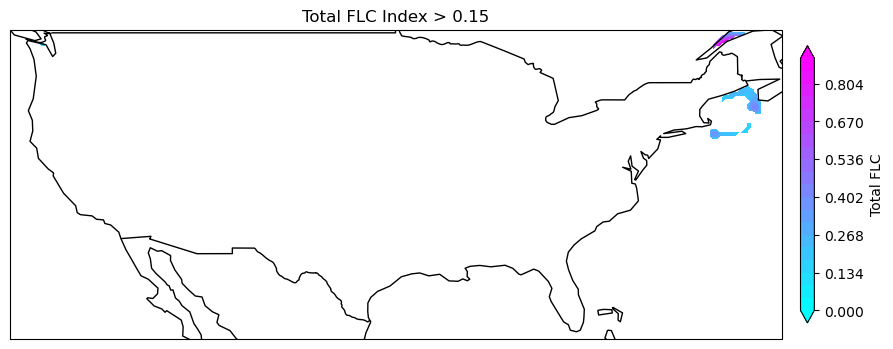

In [22]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.cool
levels = np.linspace(0, np.amax(flc_above.flc_index), 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(flc_above.longitude[0,:], flc_above.latitude[:,0], flc_above.flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index > 0.15')
clb.set_label('Total FLC')

In [23]:
flat_flc_above = np.array(flc_above.flc_index).flatten()
flat_flc_above = flat_flc_above[~np.isnan(flat_flc_above)]
print(len(flat_flc_above))

137


In [24]:
sum_sst_masked = 0
count_masked = 0

for j in range(flc_index.shape[1]):  # Loop over columns
    for i in range(flc_index.shape[0]):  # Loop over rows
        if flc_index[i][j] > 0.15:
            #print(i, j, float(dims.longitude[j].values), float(dims.latitude[i].values), "flc index", flc_index[i][j], "sst", sst_ds.sst[i][j].values)
            sum_sst_masked += sst_ds.sst[i][j].values
            count_masked += 1

#--- Flattened the 2d array in order to remove nans more easily            
flat_sst = np.array(sst_ds.sst).flatten()
flat_sst = flat_sst[~np.isnan(flat_sst)]

print("total masked sst:", sum_sst_masked)
print("total filled in sst:", np.sum(flat_sst))
print("number of masked points:", count_masked)
print("average sst filled in:", np.mean(flat_sst))
average_sst_masked = (np.sum(flat_sst) - sum_sst_masked) / (len(flat_sst))
print("average sst with flc mask:", average_sst_masked)
print("bias caused by flc masking:", average_sst_masked - np.mean(flat_sst))

total masked sst: 39444.5989074707
total filled in sst: 2583895.8
number of masked points: 137
average sst filled in: 298.37134
average sst with flc mask: 293.8165301492528
bias caused by flc masking: -4.554807741372201


## Combining the FLC index and Static Elements

In [ ]:
row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

flc_xr = xr.Dataset(
    data_vars=dict(
        flc_index=(["x","y"], flc_index)
    ),
    coords=dict(
        latitude=(["x","y"], row_meshgrid),
        longitude=(["x","y"], col_meshgrid),
    ),
    attrs=dict(description="FLC index in the designated region"),
)

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.5, 0.5, 31)

ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD, cmap=cmap, levels=levels, extend='max', alpha=0.5)
ax.contourf(dims.longitude, dims.latitude, flc_index, cmap=cmap, levels=levels, extend='both', alpha=0.5)

ax.set_title('Overlayed images ('+date+')')

ax.add_feature(cfeature.STATES)

In [ ]:
from scipy import spatial

In [ ]:
A = np.random.random((10,2))*100

In [ ]:
A

In [ ]:
pt = [float(dims.longitude[225].values), float(dims.latitude[65].values)]

In [ ]:
A[spatial.KDTree(A).query(pt)[1]]